## CAPM Simulation_South Africa

In [5]:
## To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters
## matched to real data.

In [6]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.gmm import IV2SLS
import linearmodels

In [7]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [8]:
df_MR = pd.read_csv('df_MR.csv')

In [9]:
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])

In [10]:
df_MR.set_index('Dates',inplace=True)

In [11]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [12]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR.dropna(axis = 0, how = 'all')

,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.000000,-0.026116,NaN,-0.070618,NaN,NaN,-0.013234,NaN,-0.016129,NaN,...,0.000000,NaN,0.0,NaN,NaN,-0.109199,NaN,NaN,-0.104700,0.000000
2000-01-06,-0.080043,0.000000,NaN,-0.024693,NaN,NaN,0.034932,NaN,-0.033061,NaN,...,0.081967,NaN,0.0,NaN,NaN,-0.039221,NaN,NaN,0.000000,0.000000
2000-01-07,0.117783,-0.005900,NaN,0.048790,NaN,NaN,0.094951,NaN,-0.042925,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,-0.028988,0.000000
2000-01-10,0.068993,0.015656,NaN,0.000000,NaN,NaN,0.043488,NaN,0.074108,NaN,...,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.084557,0.029559
2000-01-11,-0.068993,0.000000,NaN,-0.048790,NaN,NaN,-0.088186,NaN,0.037740,NaN,...,0.081967,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-12-27,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.080043,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.016737,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [13]:
df_Ex_SR = df_SR-df_RF.values

In [14]:
df_Ex_SR = df_Ex_SR.loc[df_MR.index,:]

In [15]:
ols_model = LinearRegression()

In [16]:
## For each stock, we fit market model regressions to esimate constant betas and residual return standard deviation;
## Then we match the simulation paramters (mean&std_dev) to the distribution of these parametes in the real data.

In [17]:
## Constant beta estimations without rolling windows
all_betas = []
all_sigmas = []

betas = []
sigmas = []
labels = []
# j is cross-sectional stock name
for j in tqdm(df_Ex_SR.columns):
    df_index = df_Ex_SR.loc[:,j].dropna().index

    if len(df_index) != 10:
#         lag = int(4*((len(df_Ex_SR.loc[df_index,j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index,j].values.astype(np.float64), sm.add_constant(df_MR.loc[df_index,:].values.astype(np.float64)))
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        res = ols.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)
        sigmas.append(s)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_sigmas.append(pd.DataFrame(sigmas))


100%|██████████| 740/740 [00:01<00:00, 389.23it/s]


In [18]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas = df_betas[(np.abs((df_betas-df_betas.mean())/df_betas.std()) <= 3).all(axis=1)]
df_betas

,Intercepts,MKT
Stocks,,
ABC.SJ.Equity,-0.000527,0.012906
ABI.SJ.Equity,-0.000128,0.065382
ABK.SJ.Equity,-0.001182,0.182993
ABR.SJ.Equity,-0.001066,-0.022444
ABU.SJ.Equity,-0.000235,0.010576
...,...,...
ZPT.SJ.Equity,-0.001798,0.079832
ZRNHDG.SJ.Equity,-0.000197,0.012835
ZRNPLY.SJ.Equity,-0.000181,0.000153


In [19]:
## The following is residual return standard deviations
df_sigmas = pd.concat([all_sigmas[0], pd.DataFrame(labels)], axis = 1)
df_sigmas.columns = ['sigmas','Stocks']
df_sigmas = df_sigmas.set_index('Stocks')
df_sigmas = df_sigmas[(np.abs((df_sigmas-df_sigmas.mean())/df_sigmas.std()) <= 3).all(axis=1)]
df_sigmas

,sigmas
Stocks,
ABC.SJ.Equity,0.019822
ABI.SJ.Equity,0.005701
ABK.SJ.Equity,0.044608
ABR.SJ.Equity,0.025737
ABU.SJ.Equity,0.008763
...,...
ZPT.SJ.Equity,0.065835
ZRNHDG.SJ.Equity,0.002140
ZRNPLY.SJ.Equity,0.000040


In [20]:
## We conduct simulations with the cross-sectional size of N=819 stocks. We randomly generat daily returns using the following procedures:
## Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.

In [21]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_betas = np.mean(df_betas.iloc[:,1])
sd_all_betas = np.std(df_betas.iloc[:,1])
print(m_all_betas, sd_all_betas)

0.16514471061904212 0.21161089569068053


In [22]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_sigmas = np.mean(df_sigmas.iloc[:,0].astype('float64'))
sd_all_sigmas = np.std(df_sigmas.iloc[:,0].astype('float64'))
print(m_all_sigmas, sd_all_sigmas)

0.01840973708300509 0.013629287305736423


In [23]:
print(m_all_sigmas*252*100, sd_all_sigmas*np.sqrt(252)*100)

463.92537449172823 21.635822854816876


## beta,i and res_sigma,i are fixed through 100 repetitions

In [24]:
# How many stocks in the simulation sample on cross-sectional scale
N = 500

In [25]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
np.mean(sim_betas_tmp), np.std(sim_betas_tmp)

(0.1591408893896226, 0.20579781537005973)

In [26]:
sim_betas = pd.DataFrame(sim_betas_tmp)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.240322,0.440322,0.449698,-0.325576,0.146589,-0.139428,0.238559,0.63029,0.235764,-0.192954,...,0.132159,0.165196,0.27876,0.328034,0.094868,0.085887,0.342205,-0.091941,0.138442,0.358642


In [27]:
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.018332071098823677, 0.013876888059404069)

In [28]:
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.001359,0.021844,0.033251,0.018222,0.015364,0.004952,0.015182,0.025631,0.017179,0.051877,...,0.064531,0.010411,0.002694,0.016545,0.001941,0.007935,0.027833,0.019334,0.011136,0.032692


In [29]:
## Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation
## equal to the sample mean and standard deviation from the data

## sim_MKT, sim_SR and res_return are changable through 100 repetitions

In [30]:
mean_MKT = np.mean(df_MR.iloc[:,0])
sd_MKT = np.std(df_MR.iloc[:,0])
print(mean_MKT, sd_MKT)

0.0002807670182166827 0.011549088535812713


In [31]:
print(mean_MKT*252*100, sd_MKT*np.sqrt(252)*100)

7.075328859060404 18.33360968113651


In [32]:
## It's important to make sure that np.mean(sim_MKT_tmp) is precisely equal to mean_MKT, otherwise the gap between 
## ex-ante and ex-post biases will be significant

In [33]:
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= len(df_MR)))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.00019055894182671193 0.0115778269582958


In [34]:
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = df_MR.index
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
Dates,
2000-01-05,0.006401
2000-01-06,0.000345
2000-01-07,0.005130
2000-01-10,0.012608
2000-01-11,-0.003597
...,...
2019-12-25,0.013580
2019-12-26,0.013474
2019-12-27,-0.013627


In [35]:
## Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and
## standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [36]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
# d = pd.DataFrame(np.zeros((N_rows, N_cols)))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.000217,0.000651,0.026383,0.003877,-0.001975,-0.004434,-0.008433,0.023181,-0.016522,0.013172,...,0.041505,-0.009420,-0.000912,0.012024,0.000860,-0.004981,0.034941,0.002268,0.001157,-0.037316
1,-0.001856,0.000904,0.008588,0.008649,-0.015443,-0.002569,0.006653,-0.009217,-0.013897,0.035893,...,0.063976,0.003553,-0.003059,-0.005528,-0.002856,0.004464,0.027019,-0.000447,-0.003195,-0.050333
2,-0.000541,-0.009473,-0.016192,0.004975,0.004901,-0.001534,0.010637,0.022543,0.015481,-0.023656,...,-0.014645,-0.023294,0.000316,-0.004070,-0.000797,-0.003823,-0.023765,-0.010196,0.021944,-0.030749
3,0.001775,0.000013,0.034769,0.002336,0.018866,0.000215,0.001267,0.017783,-0.051653,-0.023815,...,-0.054003,-0.020954,0.002567,0.010731,0.002302,-0.001245,0.029386,0.014134,-0.008200,-0.000841
4,0.000788,0.001992,-0.040605,0.020416,0.004243,0.003452,0.009545,-0.031045,-0.017161,-0.069243,...,-0.052862,0.010082,0.000899,-0.005643,0.001536,-0.004680,0.030418,-0.010381,-0.005331,0.067372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5210,0.001620,0.017133,0.037822,0.017054,0.006340,0.006490,0.002019,-0.034745,0.005453,-0.069812,...,0.150802,-0.009318,0.001513,0.003749,0.002057,0.000874,0.007675,-0.015276,0.019052,0.044711
5211,-0.000534,0.006804,0.015546,-0.013459,-0.011946,0.002981,-0.023478,0.015365,0.006325,-0.001744,...,-0.086455,-0.014815,0.001621,-0.006434,-0.003483,0.008659,-0.001284,0.049876,0.011239,0.003577
5212,-0.001051,-0.017940,0.016499,-0.018169,-0.042395,0.003038,0.013256,0.028144,-0.015889,0.030672,...,-0.017677,0.019046,-0.000756,-0.000836,0.001932,-0.008447,-0.000425,-0.021465,-0.020291,-0.049339
5213,-0.000044,-0.024390,0.050094,-0.014153,-0.004951,-0.002105,-0.008562,-0.008883,-0.026109,0.135559,...,0.040375,0.013640,0.002500,0.021052,-0.003756,-0.009741,0.020440,0.022196,0.008837,0.034135


In [37]:
## Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [38]:
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = df_Ex_SR.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.001321,0.003469,0.029262,0.001793,-0.001037,-0.005326,-0.006906,0.027216,-0.015012,0.011936,...,0.042351,-0.008363,0.000872,0.014124,0.001468,-0.004431,0.037132,0.001679,0.002043,-0.035021
2000-01-06,-0.001773,0.001056,0.008743,0.008537,-0.015393,-0.002617,0.006735,-0.008999,-0.013816,0.035827,...,0.064022,0.003610,-0.002963,-0.005415,-0.002823,0.004494,0.027137,-0.000479,-0.003147,-0.050209
2000-01-07,0.000692,-0.007214,-0.013885,0.003304,0.005653,-0.002249,0.011861,0.025777,0.016690,-0.024646,...,-0.013967,-0.022447,0.001746,-0.002387,-0.000310,-0.003382,-0.022010,-0.010668,0.022654,-0.028909
2000-01-10,0.004804,0.005565,0.040438,-0.001769,0.020715,-0.001542,0.004274,0.025730,-0.048680,-0.026247,...,-0.052337,-0.018871,0.006082,0.014867,0.003499,-0.000162,0.033701,0.012975,-0.006454,0.003681
2000-01-11,-0.000076,0.000409,-0.042222,0.021587,0.003716,0.003953,0.008687,-0.033312,-0.018009,-0.068549,...,-0.053338,0.009488,-0.000104,-0.006823,0.001194,-0.004989,0.029187,-0.010050,-0.005829,0.066082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.004883,0.023112,0.043929,0.012632,0.008331,0.004596,0.005259,-0.026186,0.008654,-0.072433,...,0.152597,-0.007074,0.005299,0.008204,0.003345,0.002040,0.012322,-0.016525,0.020932,0.049582
2019-12-26,0.002704,0.012737,0.021605,-0.017846,-0.009971,0.001103,-0.020264,0.023858,0.009502,-0.004344,...,-0.084674,-0.012589,0.005377,-0.002014,-0.002205,0.009816,0.003327,0.048637,0.013105,0.008409
2019-12-27,-0.004326,-0.023940,0.010371,-0.013732,-0.044393,0.004938,0.010005,0.019555,-0.019101,0.033301,...,-0.019478,0.016795,-0.004554,-0.005306,0.000640,-0.009617,-0.005088,-0.020212,-0.022178,-0.054226


In [39]:
from datetime import datetime
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [40]:
## sum daily stock and factor log returns to compute corresponding monthly returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:-1,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
month,,,,,,,,,,,,,,,,,,,,,
2000-01,0.002073,-0.054465,-0.098833,-0.021783,0.043589,-0.009027,-0.083490,0.197587,-0.164825,0.228760,...,0.427632,-0.072176,0.014025,-0.087481,-0.001653,-0.025171,0.097166,0.054292,-0.009424,0.102442
2000-02,0.022352,-0.024219,-0.040346,0.047157,0.167023,-0.017645,0.033066,-0.076808,-0.001617,0.359172,...,0.664116,0.091433,0.021728,0.132004,0.004520,0.010162,0.082503,0.039616,-0.023322,0.002743
2000-03,0.002809,0.061645,0.077920,-0.050170,0.089960,0.006896,0.119035,0.130114,0.118117,-0.056961,...,-0.202070,-0.053517,0.000124,0.076384,0.004580,-0.062099,-0.135627,-0.007471,-0.053820,-0.016064
2000-04,-0.001134,-0.005127,0.138815,-0.164107,-0.052146,0.051296,-0.045137,0.069265,0.003546,0.599686,...,0.005600,0.012472,0.013276,0.048385,0.010134,0.039911,0.112418,-0.024630,0.030760,0.037241
2000-05,0.003745,-0.111101,-0.024366,0.123622,-0.036372,0.007356,-0.028065,-0.199556,-0.024691,0.068303,...,-0.004318,-0.065423,-0.002686,0.090595,-0.015829,0.056091,0.024360,-0.028069,0.070729,-0.274923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,0.018467,0.120163,0.027980,0.060053,0.128051,0.028385,-0.012892,-0.018491,-0.013128,0.263759,...,0.264884,-0.015744,-0.001258,-0.003087,-0.019189,-0.021167,-0.088779,0.007089,-0.030518,-0.274579
2020-05,-0.007254,0.012019,0.001209,-0.102146,0.003896,-0.000092,-0.030043,-0.057579,0.137057,0.112744,...,-0.098151,0.024250,-0.001289,-0.021309,-0.010552,0.006537,0.021744,0.086982,-0.038100,0.296712
2020-06,-0.010789,-0.043931,-0.082280,-0.042279,0.036260,0.057138,0.047438,-0.143377,-0.071672,-0.344610,...,-0.254359,-0.023366,-0.013622,0.026861,0.009744,0.032162,0.437848,0.013522,0.018519,0.206790


In [41]:
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:-1,:]
m_sim_MKT

,RM-RF
month,
2000-01,-0.008554
2000-02,0.072472
2000-03,0.016990
2000-04,0.036727
2000-05,0.001733
...,...
2020-04,0.016498
2020-05,-0.025921
2020-06,-0.035070


In [42]:
## Step-5: For the first-stage regression in the simulation, we estimate betas using time series regression (OLS&IV)

### OLS (without rolling window)

In [43]:
# use the factor model in linearmodel module, however, this function would not allow for time-varying beta meaning that
# the result of this FM two-step regression would be the same as cross-sectional regression.
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                500   R-squared:                      0.0171
No. Factors:                          1   J-statistic:                    550.17
No. Observations:                  5215   P-value                         0.0561
Date:                  Sun, Apr 17 2022   Distribution:                chi2(499)
Time:                          00:48:07                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0002     0.0002     0.9735     0.3303     -0.0002      0.0005
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [1]:
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-np.mean(sim_MKT))/np.mean(sim_MKT)*100).values))


NameError: name 'res_ols' is not defined

In [45]:
# from linearmodels.asset_pricing import LinearFactorModelGMM
# model_GMM = LinearFactorModelGMM(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
# res_GMM = model_GMM.fit()
# res_GMM

In [46]:
all_betas_test = pd.DataFrame()
all_resids = pd.DataFrame()

# i is time in periods
for j in tqdm(sim_SR.columns):
    
    betas = []
    # j is cross-sectional stock name
#     lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
    ols = sm.OLS(sim_SR.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT.values.astype(np.float64)))
    res = ols.fit()
#     res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
    b = list(res.params)
    r = list(res.resid)
    betas.append(b)
    
    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercept', 1:'MKT'})
    all_betas_test = pd.concat([all_betas_test, df_betas], axis = 0)
    all_resids = pd.concat([all_resids, pd.DataFrame(r)], axis = 1)

100%|██████████| 500/500 [00:02<00:00, 248.32it/s]


In [47]:
all_betas_test = all_betas_test.reset_index(drop=True)
all_betas_test 

,Intercept,MKT
0,-0.000003,0.243093
1,0.000395,0.419573
2,0.000333,0.469744
3,0.000036,-0.340724
4,0.000179,0.153639
...,...,...
495,0.000009,0.094852
496,0.000148,0.322498
497,-0.000159,-0.076283
498,-0.000015,0.153104


In [48]:
alphas = pd.DataFrame(all_betas_test.Intercept).T
alphas = pd.concat([alphas]*len(sim_SR), axis = 0).reset_index(drop=True)
alphas.index = sim_SR.index
alphas.columns = sim_SR.columns
alphas.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.000003,0.000395,0.000333,0.000036,0.000179,-0.000073,0.000044,-0.000038,-0.000359,-0.000028,...,-0.000099,-0.00003,-0.000021,0.000267,-9.382625e-07,0.000009,0.000148,-0.000159,-0.000015,0.000205
2000-01-06,-0.000003,0.000395,0.000333,0.000036,0.000179,-0.000073,0.000044,-0.000038,-0.000359,-0.000028,...,-0.000099,-0.00003,-0.000021,0.000267,-9.382625e-07,0.000009,0.000148,-0.000159,-0.000015,0.000205
2000-01-07,-0.000003,0.000395,0.000333,0.000036,0.000179,-0.000073,0.000044,-0.000038,-0.000359,-0.000028,...,-0.000099,-0.00003,-0.000021,0.000267,-9.382625e-07,0.000009,0.000148,-0.000159,-0.000015,0.000205
2000-01-10,-0.000003,0.000395,0.000333,0.000036,0.000179,-0.000073,0.000044,-0.000038,-0.000359,-0.000028,...,-0.000099,-0.00003,-0.000021,0.000267,-9.382625e-07,0.000009,0.000148,-0.000159,-0.000015,0.000205
2000-01-11,-0.000003,0.000395,0.000333,0.000036,0.000179,-0.000073,0.000044,-0.000038,-0.000359,-0.000028,...,-0.000099,-0.00003,-0.000021,0.000267,-9.382625e-07,0.000009,0.000148,-0.000159,-0.000015,0.000205


In [49]:
pred_SR = pd.DataFrame(np.dot(sim_MKT, np.mat(all_betas_test.MKT.T)), columns=sim_SR.columns, index = sim_SR.index) + alphas
resids = sim_SR - (pred_SR)
resids.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.000232,0.000389,0.025922,0.003938,-0.002199,-0.004318,-0.008438,0.022906,-0.016046,0.013223,...,0.041766,-0.009411,-0.000898,0.011647,0.000875,-0.005048,0.034920,0.002326,0.001078,-0.037855
2000-01-06,-0.001854,0.000517,0.008248,0.008619,-0.015624,-0.002494,0.006611,-0.009196,-0.013532,0.035923,...,0.064084,0.003582,-0.003039,-0.005802,-0.002854,0.004452,0.026878,-0.000294,-0.003185,-0.050556
2000-01-07,-0.000552,-0.009761,-0.016628,0.005017,0.004686,-0.001427,0.010625,0.022330,0.015934,-0.023610,...,-0.014416,-0.023281,0.000332,-0.004425,-0.000785,-0.003878,-0.023812,-0.010118,0.021883,-0.031221
2000-01-10,0.001742,-0.000120,0.034183,0.002491,0.018599,0.000371,0.001300,0.017204,-0.051063,-0.023742,...,-0.053585,-0.020965,0.002576,0.010247,0.002331,-0.001367,0.029487,0.014095,-0.008370,-0.001702
2000-01-11,0.000801,0.001523,-0.040865,0.020326,0.004090,0.003501,0.009478,-0.030830,-0.016868,-0.069227,...,-0.052855,0.010124,0.000923,-0.005849,0.001529,-0.004657,0.030200,-0.010166,-0.005263,0.067355


In [50]:
all_resids.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-0.000232,0.000389,0.025922,0.003938,-0.002199,-0.004318,-0.008438,0.022906,-0.016046,0.013223,...,0.041766,-0.009411,-0.000898,0.011647,0.000875,-0.005048,0.034920,0.002326,0.001078,-0.037855
1,-0.001854,0.000517,0.008248,0.008619,-0.015624,-0.002494,0.006611,-0.009196,-0.013532,0.035923,...,0.064084,0.003582,-0.003039,-0.005802,-0.002854,0.004452,0.026878,-0.000294,-0.003185,-0.050556
2,-0.000552,-0.009761,-0.016628,0.005017,0.004686,-0.001427,0.010625,0.022330,0.015934,-0.023610,...,-0.014416,-0.023281,0.000332,-0.004425,-0.000785,-0.003878,-0.023812,-0.010118,0.021883,-0.031221
3,0.001742,-0.000120,0.034183,0.002491,0.018599,0.000371,0.001300,0.017204,-0.051063,-0.023742,...,-0.053585,-0.020965,0.002576,0.010247,0.002331,-0.001367,0.029487,0.014095,-0.008370,-0.001702
4,0.000801,0.001523,-0.040865,0.020326,0.004090,0.003501,0.009478,-0.030830,-0.016868,-0.069227,...,-0.052855,0.010124,0.000923,-0.005849,0.001529,-0.004657,0.030200,-0.010166,-0.005263,0.067355


In [51]:
corr_x_res = []

for j in tqdm(range(len(resids.columns))):
    corr = stats.pearsonr(sim_MKT.values.flatten(), resids.iloc[:,j].values)
    corr_x_res.append(corr)

100%|██████████| 500/500 [00:00<00:00, 7321.82it/s]


In [52]:
pd.DataFrame(corr_x_res).head()

,0,1
0,1.543037e-15,1.0
1,1.110223e-16,1.0
2,6.852158e-17,1.0
3,3.469447e-17,1.0
4,-1.838807e-16,1.0


In [53]:
from statsmodels.graphics.tsaplots import plot_acf

Asset_Number = 191


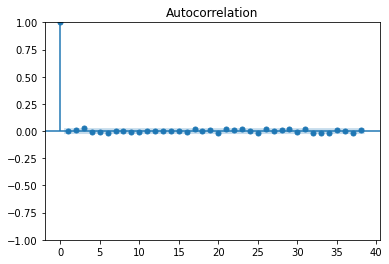

In [54]:
k = np.random.randint(0,len(sim_SR.columns))
plot_acf(resids.iloc[:,k])
print('Asset_Number = ' + str(k))
plt.show()

In [55]:
from statsmodels.stats.stattools import durbin_watson

In [56]:
## The null hypothesis of the test is that there is no serial correlation in the residuals.
all_dws = []

for j in range(len(resids.columns)):
    dw = durbin_watson(resids.iloc[:,j])
    all_dws.append(dw)

print(np.mean(all_dws))

2.00013151721807


In [57]:
beta_err = sim_betas - all_betas_test.MKT

In [58]:
durbin_watson(beta_err.T)

array([2.07014608])

In [59]:
lamdas = []

for i in tqdm(range(len(sim_SR))):
    ols = sm.OLS(sim_SR.iloc[i,:], sim_betas.T)
    res = ols.fit()
    l = list(res.params)
    lamdas.append(l)

100%|██████████| 5215/5215 [00:05<00:00, 1033.20it/s]


In [60]:
print(np.mean(lamdas), mean_MKT)

0.00017909584852377183 0.0002807670182166827


## OLS (Time-varying Betas)

In [61]:
# how many years in the rolling window periods
n = 5

In [62]:
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 1260


In [63]:
all_betas = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
#         lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        betas.append(b)

    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)

100%|██████████| 187/187 [00:43<00:00,  4.30it/s]


In [64]:
all_betas[0]

,Intercepts,MKT
0,0.000027,0.239750
1,0.000047,0.408024
2,0.000827,0.510423
3,0.000207,-0.307073
4,0.000154,0.173550
...,...,...
495,0.000236,0.089859
496,-0.000819,0.412785
497,-0.000441,-0.135128
498,0.000140,0.111584


In [65]:
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9663520337562215 3640.445536348702


In [66]:
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 60


In [67]:
# sum daily market return to compute corresponding monthly returns
m_MR = df_MR
m_MR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_MR = m_MR.groupby('month').sum()
df_MR = df_MR.drop(['month'], axis = 1)
m_MR = m_MR.iloc[:-1,:]
m_MR

,MR_RF
month,
2000-01,0.0154
2000-02,-0.0955
2000-03,-0.0024
2000-04,-0.0693
2000-05,-0.0119
...,...
2020-04,-0.0695
2020-05,0.0382
2020-06,-0.0010


In [68]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:00<00:00, 733.93it/s]


In [69]:
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.016313,-0.038579
1,-0.002806,-0.026937
2,-0.010871,-0.024258
3,-0.010653,0.057024
4,-0.005305,-0.057059
...,...,...
182,0.004144,-0.013640
183,0.002527,0.023232
184,-0.005669,0.016531
185,-0.001646,-0.009050


In [70]:
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.003543,-0.009205,0.012733,0.010486,-0.016284,0.005411,0.009449,0.004798,-0.010533,0.000308,...,-0.006593,0.000358,0.006406,0.009889,0.004338,0.003497,0.010203,-0.005663,-0.006904,-0.002097
1,-0.056709,-0.137175,0.141429,-0.106274,0.021183,0.069410,0.039912,0.034288,0.040898,-0.105047,...,-0.132032,0.185368,-0.006311,0.057518,0.131111,0.061537,0.108584,0.011313,-0.038815,0.009027
2,-0.039991,0.123632,-0.029518,0.044806,-0.025912,0.165752,0.115067,-0.260256,0.052105,-0.021177,...,-0.201404,0.321828,-0.187234,0.031780,-0.057796,0.239027,0.014493,-0.001034,-0.076353,-0.065908
3,0.068900,0.178397,0.174584,0.053368,0.065508,0.081403,0.018218,-0.016729,-0.057469,0.055643,...,-0.090050,0.057355,0.011111,0.128687,-0.009631,-0.015065,0.064288,-0.091594,-0.043331,-0.036275
4,-0.082509,0.051495,0.029093,-0.132523,0.074276,-0.004614,0.050955,-0.011140,0.018648,-0.038546,...,-0.145574,0.069533,0.070280,-0.150434,0.061359,0.011015,0.123050,0.007753,0.038970,-0.044921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.007815,-0.065292,0.031330,0.011212,-0.028921,-0.022326,-0.016336,0.098176,0.026859,0.030928,...,-0.049867,0.068058,0.065258,0.028098,0.068937,-0.031717,-0.026208,0.010357,0.034831,-0.068724
496,-0.132272,0.342668,0.024693,0.269735,0.003854,-0.102443,0.086267,-0.003273,-0.052794,0.201834,...,0.134496,0.026504,0.145451,0.213526,-0.189570,-0.104626,-0.099022,0.021786,0.442452,0.148971
497,-0.041402,-0.134168,-0.041235,0.091269,-0.207636,-0.025233,0.003975,0.061642,0.053734,0.119899,...,0.063675,-0.134535,0.034683,-0.046260,-0.009542,0.049199,0.006397,0.093945,0.014453,-0.032555
498,-0.067081,0.015762,-0.071149,-0.045012,-0.033925,0.009894,-0.091184,-0.138521,-0.020541,0.024648,...,-0.044655,-0.084947,0.056041,-0.005527,-0.078075,-0.031620,-0.036139,-0.034669,0.021419,-0.019015


In [71]:
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)

Ttest_1sampResult(statistic=array([-1.516194  ,  1.19739941]), pvalue=array([0.13116796, 0.23267468]))

In [72]:
## ***Risk Premium estimate for one simulation
np.mean(all_lambdas_OLS[0].iloc[:,1]) # simulation market premium
## ***Corresponding true simulation parameters, 0.0002807670182166827 is our true daily market risk premium, i.e. 0.07075328859060404 per annum
np.mean(m_MR) #true market premium
print(np.mean(m_MR.values), np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.00593024193548387 0.004397332086630865


/Users/runxinlin/opt/anaconda3/envs/Research_Codes_2021/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [73]:
# Test whether the betas in FM-2 is endougenous

In [74]:
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print(np.mean(corr_betas_res), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "x is Exogenous")

-4.786723602160601e-18 x is Exogenous


In [75]:
m_MR_tmp = m_MR.iloc[rollingW+1:len(m_MR),:]
m_sim_MKT_tmp = m_sim_MKT.iloc[rollingW+1:len(m_MR),:]

In [76]:
print(np.mean(m_MR.values),np.mean(all_lambdas_OLS[0].iloc[:,1].values))

0.00593024193548387 0.004397332086630863


In [77]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))

ex-ante bias(%): -25.849027164992545
ex-post bias(%): 6.038326934222072


In [78]:
## The Ex-ante RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07108081868988955

In [79]:
## The Ex-post RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.0737792282591704

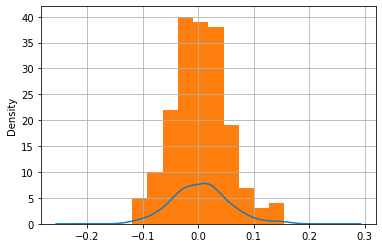

In [80]:
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

## IV(Time-varying Betas)

In [81]:
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

1260 187


In [82]:
all_betas_ev = []
all_betas_iv = []

# i is time in periods
for i in tqdm(range(periods)):

    sim_MKT_tmp = sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is cross-sectional stock label
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 187/187 [02:27<00:00,  1.26it/s]


In [83]:
all_betas_ev[0]

,0
0,0.240463
1,0.367181
2,0.439816
3,-0.336756
4,0.167778
...,...
495,0.100765
496,0.279923
497,-0.124588
498,0.155752


In [84]:
all_betas_iv[0]

,0
0,0.238985
1,0.451155
2,0.585828
3,-0.275484
4,0.179462
...,...
495,0.078197
496,0.554752
497,-0.146104
498,0.064140


In [85]:
## Calculating the estimated lambdas

In [86]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

187 60


In [87]:
# A rule of thumb is the first stage (i.e., the regression of x on the instrument and any covariates)
# should have an F statistic of at least 10.

fvalues = []

for i in tqdm(range(len(all_betas_ev))):
    ols = sm.OLS(all_betas_ev[i].values.astype(np.float64), sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
    res = ols.fit()
    f = res.fvalue
    fvalues.append(f)


100%|██████████| 187/187 [00:00<00:00, 2106.80it/s]


In [88]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     1663.
Date:                Sun, 17 Apr 2022   Prob (F-statistic):          7.41e-161
Time:                        00:51:27   Log-Likelihood:                 420.51
No. Observations:                 500   AIC:                            -837.0
Df Residuals:                     498   BIC:                            -828.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0269      0.006      4.696      0.000       0.016       0.038
x1             0.8720      0.021     40.785      0.000       0.830       0.914
==============================================================================
Omnibus:                       39.795   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.802
Skew:                           0.074   Prob(JB):                     2.46e-39
Kurtosis:                       5.918   Cond. No.                         4.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
pd.DataFrame(fvalues).describe()

,0
count,187.000000
mean,1560.244117
std,134.644715
min,1332.648369
25%,1457.554944
50%,1536.374479
75%,1642.155932
max,1902.892924


In [90]:
from linearmodels.iv.model import IV2SLS
# from linearmodels.iv.model import IVGMM
all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    iv = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = np.ones(len(m_sim_SR.T), dtype=np.uint8),\
                endog = all_betas_ev[i].values.astype(np.float64),\
                instruments = all_betas_iv[i].values.astype(np.float64))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:00<00:00, 191.39it/s]


In [91]:
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              dependent   R-squared:                      0.0209
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0190
No. Observations:                 500   F-statistic:                    3.3214
Date:                Sun, Apr 17 2022   P-value (F-stat)                0.0684
Time:                        00:51:29   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog          -0.0012     0.0056    -0.2096     0.8339     -0.0121      0.0098
endog          0.0484     0.0265     1.8225     0.0684     -0.0036      0.1004
==============================================================================

Endogenous: endog
Instruments: instruments
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [92]:
res.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 4.6209
P-value: 0.0321
Distributed: F(1,497)
WaldTestStatistic, id: 0x7fdf8a30a370

In [93]:
# from statsmodels.sandbox.regression.gmm import IV2SLS

# all_lambdas_IV = []
# all_resids_IV = []
# # i is time

# m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

# lambdas = []
# resids = []
# index_times = list(m_sim_SR_tmp_T.columns)

# for k in tqdm(m_sim_SR_tmp_T.columns):
    
#     i = int(index_times.index(k) / holding)
    
#     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = sm.add_constant(all_betas_ev[i].values.astype(np.float64)),\
#                 instrument = sm.add_constant(all_betas_iv[i].values.astype(np.float64)))
# #     iv = IV2SLS(endog = m_sim_SR_tmp_T.loc[:,k].values,exog = all_betas_ev[i].values.astype(np.float64),instrument = all_betas_iv[i].values.astype(np.float))
#     res = iv.fit()
#     l = list(res.params)
#     r = list(res.resid)
#     lambdas.append(l)
#     resids.append(r)

# all_lambdas_IV.append(pd.DataFrame(lambdas))
# all_resids_IV.append(pd.DataFrame(resids))


In [94]:
# Use the IV estimator equation to calculate lambdas

In [95]:
lam = []
for i in range(periods):
    a = np.dot(np.array(all_betas_iv[i]).T,np.array(all_betas_ev[i]))
    b = np.dot(np.array(all_betas_iv[i]).T, np.array(m_sim_SR_tmp_T.iloc[:,i]))
    l = np.linalg.inv(a)*b
    lam.append(l)

In [96]:
print(np.mean(lam),stats.ttest_1samp(lam, 0.0)[0])

0.0030468585602712764 [[0.77451731]]


In [97]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.005093,-0.010184,0.014214,0.010227,-0.015533,0.005053,0.008844,0.005591,-0.011444,0.000707,...,-0.007317,-0.000538,0.006190,0.008481,0.003664,0.004134,0.010206,-0.006254,-0.007231,-0.000833
1,-0.054409,-0.140771,0.143095,-0.103585,0.018901,0.073889,0.040118,0.036818,0.034955,-0.106605,...,-0.134607,0.183308,-0.008351,0.055299,0.130811,0.062604,0.109336,0.010461,-0.039813,0.012892
2,-0.037490,0.118489,-0.026002,0.048006,-0.026573,0.168851,0.114302,-0.256770,0.044256,-0.023189,...,-0.201626,0.318748,-0.180589,0.022521,-0.065429,0.243317,0.012140,-0.005348,-0.077038,-0.063637
3,0.058560,0.183233,0.165318,0.056737,0.059478,0.085113,0.022486,-0.021183,-0.054161,0.051602,...,-0.086789,0.061777,0.010725,0.136749,-0.004590,-0.018878,0.064914,-0.088061,-0.041787,-0.041123
4,-0.082559,0.051146,0.028651,-0.131439,0.073249,-0.003384,0.051492,-0.011048,0.016959,-0.039965,...,-0.145624,0.069986,0.068432,-0.148221,0.064234,0.009767,0.124026,0.009119,0.038917,-0.044081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.007164,-0.064389,0.030748,0.010772,-0.029044,-0.022236,-0.015941,0.097509,0.027800,0.031075,...,-0.049393,0.068657,0.065529,0.028922,0.068914,-0.032023,-0.026375,0.010581,0.035018,-0.069495
496,-0.135142,0.337724,0.024995,0.275190,-0.000317,-0.096164,0.087374,-0.000578,-0.060412,0.198538,...,0.133965,0.024962,0.147471,0.209815,-0.192548,-0.102908,-0.099279,0.020511,0.441775,0.151921
497,-0.046252,-0.130687,-0.046229,0.091387,-0.209230,-0.027531,0.004535,0.059353,0.058432,0.120666,...,0.065716,-0.132059,0.036043,-0.042726,-0.007455,0.047443,0.006090,0.095223,0.015385,-0.035631
498,-0.065427,0.016895,-0.070100,-0.047749,-0.031551,0.007557,-0.091710,-0.139039,-0.018273,0.026244,...,-0.044424,-0.084697,0.056588,-0.005585,-0.079464,-0.031126,-0.036732,-0.035059,0.021630,-0.020312


In [98]:
# # Plot the distrubtion of the residuals
# label = all_resids_IV.index
# index = all_resids_IV.columns

# # Get the shape of df_residuals
# shape = all_resids_IV.shape

# plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)

# for j in tqdm(range(shape[1])):
#     plt.plot(all_resids_IV.iloc[:,j],)  

# plt.title('The distrubtion of residuals')
# # plt.xticks(np.arange(min(label), max(label)+1, 12), fontsize = 6)
# plt.xticks([], [])
# plt.yticks(fontsize = 6)
# # plt.xlabel('Stock Labels', fontsize = 10)
# plt.ylabel('Residuals', fontsize = 10)
# plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5, axis='y')
# plt.tight_layout()
# plt.show()

In [99]:
## test whether beta_iv (instrumental variables) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print(np.mean(corr_iv_res), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

1.5468724043803882e-18 IV is Exogenous


In [100]:
## test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print(np.mean(corr_ev_res), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


-0.0010429047551310628 EV is Endogenous


In [101]:
## weak instrument variable test
## the following calculate the average cross-sectional correlations between odd- and even-month betas 

In [102]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.8700369518496619 IV is Strong


In [103]:
## and also calculate the average cross-sectional correlations between estimated and true betas 

In [104]:
corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print(np.mean(corr_ev_true), stats.ttest_1samp(corr_ev_true, 0.0)[0])

0.9342250978166771 2119.837780209492


In [105]:
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,-0.013371,-0.057148
1,-0.004566,-0.015460
2,-0.007944,-0.042325
3,-0.011389,0.060669
4,-0.003721,-0.066256
...,...,...
182,0.005449,-0.021496
183,0.002402,0.023664
184,-0.006842,0.023595
185,-0.002196,-0.005465


In [106]:
stats.ttest_1samp(all_lambdas_IV[0], 0.0)

Ttest_1sampResult(statistic=array([-1.63915784,  1.19675439]), pvalue=array([0.1028707 , 0.23292545]))

In [107]:
all_lambdas_IV[0].describe()

,0,1
count,187.000000,187.000000
mean,-0.000717,0.004737
std,0.005980,0.054125
min,-0.015431,-0.128434
25%,-0.004843,-0.030245
50%,-0.000478,0.004758
75%,0.003618,0.035553
max,0.018465,0.185447


In [108]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   

ex-ante bias(%): -20.125764340328924
ex-post bias(%): 14.222780776554442


In [109]:
## The Ex-ante RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.07371360261275517

In [110]:
## The Ex-post RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.07675146764260497

### OLS with beta_ev

In [111]:
from linearmodels.iv.model import IV2SLS

all_lambdas_ols = []
all_resids_ols = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    ols = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = pd.concat([pd.DataFrame(np.ones(len(m_sim_SR.T), dtype=np.uint8)).T, all_betas_ev[i].T], axis =0,ignore_index=True).T,\
                endog = None,\
                instruments = None)
    res = ols.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_ols.append(pd.DataFrame(lambdas))
all_resids_ols.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:01<00:00, 155.49it/s]


In [112]:
all_resids_ols = pd.DataFrame(all_resids_ols[0].T)
all_resids_ols

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.002217,-0.008521,0.011509,0.010866,-0.017001,0.005718,0.009961,0.004205,-0.010080,-0.000227,...,-0.006098,0.001048,0.006339,0.011143,0.005113,0.002889,0.010366,-0.005164,-0.006643,-0.002987
1,-0.061610,-0.137208,0.137297,-0.102141,0.015588,0.075067,0.042099,0.034400,0.037335,-0.108439,...,-0.132228,0.186403,-0.008050,0.060687,0.134143,0.059740,0.109696,0.012904,-0.038532,0.008207
2,-0.047170,0.124436,-0.035678,0.050301,-0.031839,0.170980,0.117879,-0.260617,0.048041,-0.025840,...,-0.195751,0.326390,-0.179819,0.036285,-0.058759,0.237583,0.012889,-0.000261,-0.074374,-0.073390
3,0.075382,0.173399,0.181319,0.052790,0.068537,0.080985,0.015550,-0.012665,-0.062542,0.057427,...,-0.093042,0.053643,0.009924,0.122451,-0.012371,-0.012189,0.064056,-0.093890,-0.044977,-0.029449
4,-0.082955,0.051035,0.028832,-0.131545,0.073494,-0.003558,0.051200,-0.010447,0.016368,-0.039576,...,-0.146613,0.068700,0.068278,-0.150972,0.062705,0.011082,0.123857,0.007976,0.038397,-0.042177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.009055,-0.065413,0.032414,0.010334,-0.028041,-0.022751,-0.016806,0.098509,0.026815,0.031624,...,-0.050176,0.067639,0.065433,0.027209,0.068110,-0.031332,-0.026452,0.010062,0.034742,-0.068486
496,-0.139365,0.340809,0.019977,0.276319,-0.002906,-0.095343,0.088753,-0.002786,-0.058239,0.197129,...,0.136616,0.028410,0.147809,0.215851,-0.189264,-0.105730,-0.098945,0.022782,0.442819,0.148099
497,-0.036670,-0.136291,-0.037111,0.089418,-0.204711,-0.028910,0.002219,0.062407,0.055427,0.122726,...,0.062493,-0.136251,0.035662,-0.049543,-0.011477,0.050900,0.005687,0.092484,0.013885,-0.030142
498,-0.065413,0.016765,-0.069887,-0.047786,-0.031467,0.007513,-0.091783,-0.139140,-0.018175,0.026100,...,-0.044666,-0.085012,0.056565,-0.005995,-0.079286,-0.031279,-0.036731,-0.035048,0.021668,-0.020451


In [113]:
all_lambdas_ols[0].rename(columns = {0:'Intercepts', 1:'MKT'})

,Intercepts,MKT
0,-0.018701,-0.023021
1,-0.001395,-0.035432
2,-0.013103,-0.009833
3,-0.010168,0.053014
4,-0.006522,-0.048689
...,...,...
182,0.003106,-0.006960
183,0.002697,0.021827
184,-0.004843,0.011117
185,-0.001108,-0.012201


In [114]:
corr_betas_ev_res = []

for i in range(np.shape(all_resids_ols)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_ols.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_ev_res.append(corr)
    
# expression_if_true if condition else expression_if_false
print(np.mean(corr_betas_ev_res), "EV is Endogenous" if np.mean(corr_betas_ev_res).round(10)!=0 else "EV is Exogenous")


-3.991255484165889e-18 EV is Exogenous


In [115]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_MR_tmp.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_sim_MKT_tmp.values))/np.mean(m_sim_MKT.values)*100))   
## The result is almost the same as the OLS section

ex-ante bias(%): -39.28555240697626
ex-post bias(%): 13.372702983203094
